In [14]:
import rioxarray as rio
import xarray as xr
import glob
import os
import numpy as np
import requests
import geopandas as gpd
from pathlib import Path
from datetime import datetime
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
%matplotlib inline

all_scenes_f_precip = Path('/scratch/waves/rhone-ecostress/rasters/chirps-clipped')
all_scenes_f_et = Path('/home/serdp/rhone/rhone-ecostress/rasters/eeflux/BRC')

all_precip_paths = list(all_scenes_f_precip.glob("*"))
all_isp_et_paths = list(all_scenes_f_et.glob("*.tif"))

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 55, 'height': 89, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_GRS80_ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",46.5],PARAMETER["central_meridian",3],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",44],PARAMETER["false_easting",700000],PARAMETER["false_northing",6600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(3940.0, 0.0, 752344.6729321405,
       0.0, -5550.0, 6682060.744602234), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
52.3 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


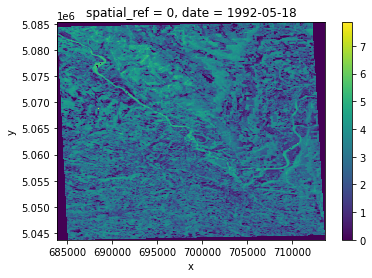

In [15]:
# for some reason the fll value is not correct. this is the correct bad value to mask by
testf = all_precip_paths[0]
x = rio.open_rasterio(testf)
badvalue = np.unique(x.where(x != x._FillValue).sel(band=1))[0]

def chirps_path_date(path):
    _, _, year, month, day, _ = path.name.split(".") # Change this line accordingly based on format of eeflux dates
    day = day.split("-")[0]
    return datetime(int(year), int(month), int(day))


def open_chirps(path):
    data_array = rio.open_rasterio(path) #chunks makes i lazyily executed
    data_array = data_array.sel(band=1).drop("band") # gets rid of old coordinate dimension since we need bands to have unique coord ids
    data_array["date"] = chirps_path_date(path) # makes a new coordinate
    return data_array.expand_dims({"date":1}) # makes this coordinate a dimension



### data is not tiled so not a good idea to use chunking
#https://github.com/pydata/xarray/issues/2314

import rasterio
with rasterio.open(testf) as src:
    print(src.profile)

len(all_precip_paths) * 41.7 / 10e3 # convert from in to mm

%timeit open_chirps(testf)

all_daily_precip_path = "/home/serdp/ravery/rhone-ecostress/netcdfs/all_chirps_daily_i.nc"

if Path(all_daily_precip_path).exists():
    
    all_chirps_arr = xr.open_dataarray(all_daily_precip_path)
    all_chirps_arr = all_chirps_arr.sortby("date")
else:

    daily_chirps_arrs = []

    for path in all_precip_paths:

        daily_chirps_arrs.append(open_chirps(path)) 
        
    all_chirps_arr = xr.concat(daily_chirps_arrs, dim="date")
    
    all_chirps_arr = all_chirps_arr.sortby("date")

    all_chirps_arr.to_netcdf(all_daily_precip_path)

def eeflux_path_date(path):
    year, month, day, _, _ = path.name.split("-")
    return datetime(int(year), int(month), int(day))

def open_eeflux(path, da_for_match):
    data_array = rio.open_rasterio(path) #chunks makes i lazyily executed
    data_array.rio.reproject_match(da_for_match)
    data_array = data_array.sel(band=1).drop("band") # gets rid of old coordinate dimension since we need bands to have unique coord ids
    data_array["date"] = eeflux_path_date(path) # makes a new coordinate
    return data_array.expand_dims({"date":1}) # makes this coordinate a dimension

da_for_match = rio.open_rasterio(all_isp_et_paths[0])
daily_eeflux_arrs = [open_eeflux(path, da_for_match) for path in all_isp_et_paths]
all_eeflux_arr = xr.concat(daily_eeflux_arrs, dim="date")
all_daily_eeflux_path = "/home/serdp/ravery/rhone-ecostress/netcdfs/all_eeflux_daily_i.nc"
all_eeflux_arr.to_netcdf(all_daily_eeflux_path)

all_eeflux_arr[-3,:,:].plot.imshow()

all_eeflux_arr = all_eeflux_arr.sortby("date")

In [16]:
ey = max(all_eeflux_arr['date.year'].values)

In [19]:
def years_list(all_eeflux_arr):
    ey = max(all_eeflux_arr['date.year'].values)
    sy = min(all_eeflux_arr['date.year'].values)
    start_years = range(sy, ey)
    end_years = range(sy, ey)
    return list(zip(start_years, end_years))

def group_by_custom_doy(all_eeflux_arr, doy_start, doy_end):
    start_end_years = years_list(all_eeflux_arr)
    water_year_arrs = []
    for water_year in start_end_years:
        start_mask = ((all_eeflux_arr['date.dayofyear'].values > doy_start) & (all_eeflux_arr['date.year'].values == water_year[0]))
        end_mask = ((all_eeflux_arr['date.dayofyear'].values < doy_end) & (all_eeflux_arr['date.year'].values == water_year[0]))
        water_year_arrs.append(all_eeflux_arr[start_mask | end_mask])
    return water_year_arrs
doystart = 125 # Edit these variables to change doy length of year
doyend = 275
water_year_arrs = group_by_custom_doy(all_eeflux_arr, doystart, doyend)

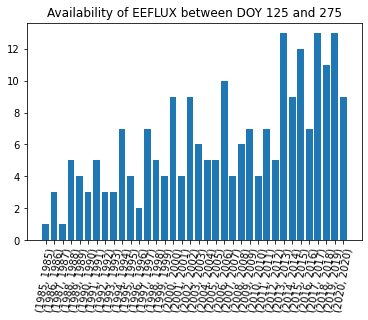

In [20]:
group_counts = list(map(lambda x: len(x['date']), water_year_arrs))
year_tuples = years_list(all_eeflux_arr)

indexes = np.arange(len(year_tuples))
plt.bar(indexes, group_counts)
degrees = 80
plt.xticks(indexes, year_tuples, rotation=degrees, ha="center")
plt.title("Availability of EEFLUX between DOY 125 and 275")
plt.savefig("eeflux_availability.png")

In [21]:
def sum_seasonal_precip(precip_arr, eeflux_group_arr):
    return precip_arr.sel(date=slice(eeflux_group_arr.date.min(), eeflux_group_arr.date.max())).sum(dim="date")

In [22]:
for index, eeflux_group in enumerate(water_year_arrs):
    if len(eeflux_group['date']) > 0:
        seasonal_precip = sum_seasonal_precip(all_chirps_arr, eeflux_group)
        seasonal_et = eeflux_group.integrate(dim="date", datetime_unit="D")
        year_range = year_tuples[index]
        pname = f"seasonal_chirps_{year_range[0]}_{doystart}_{doyend}.tif"
        eename = f"seasonal_eeflux_integrated_{year_range[0]}_{doystart}_{doyend}.tif"
        seasonal_precip.rio.to_raster(pname)
        seasonal_et.rio.to_raster(eename)
# This chunk actually outputs the rasters

In [12]:
seasonal_precip # This just shows the array - corner cells have empty values b/c of projection mismatch @ edge of raster

<xarray.DataArray (y: 89, x: 55)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * y            (y) float64 6.679e+06 6.674e+06 ... 6.196e+06 6.191e+06
  * x            (x) float64 7.543e+05 7.583e+05 ... 9.631e+05 9.671e+05
    spatial_ref  int64 ...

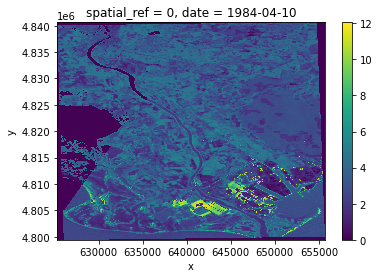

In [10]:
water_year_arrs[0][0].plot.imshow()

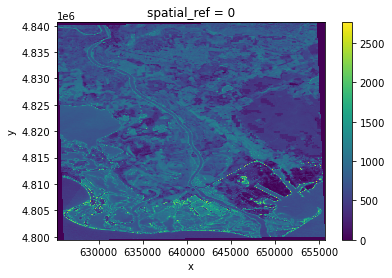

In [11]:
water_year_arrs[0].integrate(dim="date", datetime_unit="D").plot.imshow()

In [41]:
all_eeflux_arr.integrate(dim="date", datetime_unit="D")

<xarray.DataArray (y: 1374, x: 1013)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * y            (y) float64 4.841e+06 4.841e+06 ... 4.799e+06 4.799e+06
  * x            (x) float64 6.253e+05 6.253e+05 ... 6.556e+05 6.556e+05
    spatial_ref  int64 0

In [21]:
import pandas as pd
import numpy as np

labels = ['<=2', '3-9', '>=10']
bins = [0,2,9, np.inf]
pd.cut(all_eeflux_arr, bins, labels=labels)

ValueError: Input array must be 1 dimensional

In [22]:
all_eeflux_arr

<xarray.DataArray (date: 353, y: 1374, x: 1013)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * y            (y) float64 4.841e+06 4.841e+06 ... 4.799e+06 4.799e+06
  * x            (x) float64 6.253e+05 6.253e+05 ... 6.556e+05 6.556e+05
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 1984-04-10 1984-06-13 ... 2020-09-04
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [38]:
import pandas as pd

all_scene_ids = [str(i) for i in list(all_scenes_f.glob("L*"))]
df = pd.DataFrame({"scene_id":all_scene_ids}).reindex()
split_vals_series = df.scene_id.str.split("/")

dff = pd.DataFrame(split_vals_series.to_list(), columns=['_', '__', '___', '____', '_____', '______', 'fname'])

df['date'] = dff['fname'].str.slice(10,18)

df['pathrow'] = dff['fname'].str.slice(4,10)

df['sensor'] = dff['fname'].str.slice(0,4)

df['datetime'] = pd.to_datetime(df['date'])

df = df.set_index("datetime").sort_index()

NameError: name 'all_scenes_f' is not defined

In [ ]:
marc_df = df['2014-01-01':'2019-12-31']

In [ ]:
marc_df = marc_df[marc_df['sensor']=="LC08"]

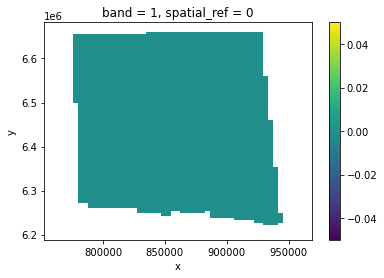

In [43]:

x.where(x != badvalue).sel(band=1).plot.imshow()

In [18]:
# Evan additions

year_tuples = years_list(all_eeflux_arr)
year_tuples


NameError: name 'sy' is not defined